<a href="https://colab.research.google.com/github/tuananh11052000/CS114.K21/blob/master/CUOI%20KY/detect_animal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kết nối với google driver để truy xuất dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Import các thư viện cần thiết để sử dụng cho các shell tiếp theo

In [2]:
import glob
import cv2
import numpy as np
import os
import random
import skimage
from skimage import feature
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

Định nghĩa hàm HOG rút trích đặc trưng sử dụng trọng số truyền vào

In [4]:
class HOG:
    def __init__(self, orientations=12, pixelsPerCell=(2, 2), cellsPerBlock=(2, 2), normalize=True):
        # store the number of orientations, pixels per cell, cells per block, and
        # whether normalization should be applied to the image
        self.orientations = orientations
        self.pixelsPerCell = pixelsPerCell
        self.cellsPerBlock = cellsPerBlock
        self.normalize = normalize

    def describe(self, image):
        # compute Histogram of Oriented Gradients features for scikit-image < 0.13
        if int(skimage.__version__.split(".")[1]) < 13:
            
            hist = feature.hog(image, orientations=self.orientations, pixels_per_cell=self.pixelsPerCell,
                               cells_per_block=self.cellsPerBlock, transform_sqrt=self.normalize)

        # otherwise comput Histogram of Oriented Gradients features for scikit-image >= 0.13
        else:
            hist = feature.hog(image, orientations=self.orientations, pixels_per_cell=self.pixelsPerCell,
                               cells_per_block=self.cellsPerBlock, transform_sqrt=self.normalize, block_norm="L1")

        hist[hist < 0] = 0

        # return the histogram
        return hist



*   Lấy liệu từ google driver
*   Đọc ảnh và gán nhãn



In [5]:
datasetPaths = []
labels = []
data = []
for linkimage in glob.iglob('/content/drive/My Drive/Colab Notebooks/detect_animal_gray/*/*.png', recursive=True):
    datasetPaths.append(linkimage);
random.shuffle(datasetPaths)
for path in datasetPaths:
  labels.append(path.split(os.path.sep)[-2])
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img, (140, 110))
  data.append(img)

*   Chuyển nhãn về dạng số để phù hợp cho việc train model
*   Trong bước này, ảnh không có động vật là 1
*   Ảnh có động vật 0

In [6]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
le.classes_
lb = le.transform(labels)

In [10]:
print(labels)
print(lb)
label_1 = 0
label_0 = 0
for i in lb:
  if i == 0:
    label_0 = label_0 + 1
  else:
    label_1 = label_1 + 1
print("so luong nhan 0 la: " + str(label_0))
print("so luong nhan 1 la: " + str(label_1))

['animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'animal', 'non_animal', 'animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'animal', 'animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'animal', 'animal', 'non_animal', 'non_animal', 'non_animal', 'animal', 'non_animal', 'animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'animal', 'animal', 'non_animal', 'non_animal', 'non_animal', 'animal', 'animal', 'non_animal', 'non_animal', 'non_animal', 'animal', 'non_animal', 'non_animal', 'non_animal', 'non_animal', 'animal', 'no

Sử dụng HOG để rút trích đặc trưng





In [11]:
features = []
hog = HOG(orientations=12, pixelsPerCell=(4, 4), cellsPerBlock=(2, 2), normalize=True)
for img in data:
  features.append(hog.describe(img))

Chia bộ train test theo tỷ lệ 85-15

In [13]:
x_train, x_test, y_train, y_test = train_test_split(features, lb, test_size=0.15)
count_0 = 0
count_1 = 1
for i in y_test:
  if i == 0:
    count_0 = count_0 + 1
  else:
    count_1 = count_1 + 1
print("so luong nhan 0 la: " + str(count_0))
print("so luong nhan 1 la: " + str(count_1))

so luong nhan 0 la: 69
so luong nhan 1 la: 296


*   Tính toán các tham số phù hợp cho model.
*   Sử dụng SVM để train trên bộ feature đã thu được.



In [16]:
from sklearn.model_selection import GridSearchCV
param_grid = { 'C':[0.01, 0.1, 1, 10],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel':['linear']}
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
grid.fit(x_train, y_train)
print(grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=0.01, gamma=1, kernel=linear ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... C=0.01, gamma=1, kernel=linear, score=0.988, total=  58.0s
[CV] C=0.01, gamma=1, kernel=linear ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   58.0s remaining:    0.0s


[CV] ...... C=0.01, gamma=1, kernel=linear, score=0.985, total=  57.1s
[CV] C=0.01, gamma=1, kernel=linear ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


[CV] ...... C=0.01, gamma=1, kernel=linear, score=0.995, total=  57.6s
[CV] C=0.01, gamma=1, kernel=linear ..................................
[CV] ...... C=0.01, gamma=1, kernel=linear, score=0.988, total=  54.3s
[CV] C=0.01, gamma=1, kernel=linear ..................................
[CV] ...... C=0.01, gamma=1, kernel=linear, score=0.990, total=  56.8s
[CV] C=0.01, gamma=0.1, kernel=linear ................................
[CV] .... C=0.01, gamma=0.1, kernel=linear, score=0.988, total=  57.8s
[CV] C=0.01, gamma=0.1, kernel=linear ................................
[CV] .... C=0.01, gamma=0.1, kernel=linear, score=0.985, total=  56.9s
[CV] C=0.01, gamma=0.1, kernel=linear ................................
[CV] .... C=0.01, gamma=0.1, kernel=linear, score=0.995, total=  57.6s
[CV] C=0.01, gamma=0.1, kernel=linear ................................
[CV] .... C=0.01, gamma=0.1, kernel=linear, score=0.988, total=  54.4s
[CV] C=0.01, gamma=0.1, kernel=linear ................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 72.1min finished


{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}


In [17]:
model = SVC(kernel="linear", C = 0.1, gamma = 1, probability=False, random_state=42)
model.fit(x_train, y_train)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

Đánh giá model

In [18]:
from sklearn.metrics import accuracy_score
pred = model.predict(x_test)
print('acc: ', accuracy_score(pred, y_test))

acc:  0.9972527472527473


In [19]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred, target_names = target_names))

              precision    recall  f1-score   support

     class 0       1.00      0.99      0.99        69
     class 1       1.00      1.00      1.00       295

    accuracy                           1.00       364
   macro avg       1.00      0.99      1.00       364
weighted avg       1.00      1.00      1.00       364



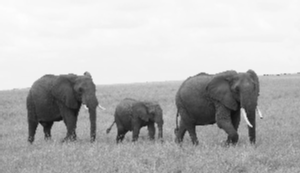

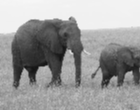

[0]


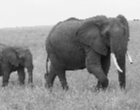

[0]


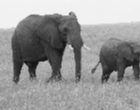

[0]


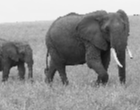

[0]


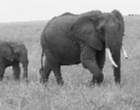

[0]


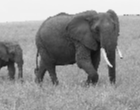

[0]


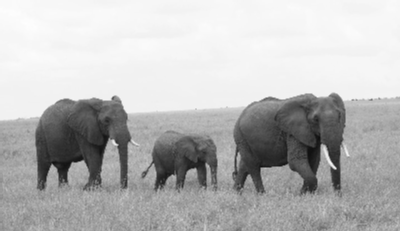

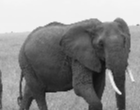

[0]


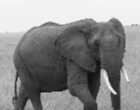

[0]


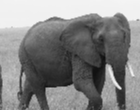

[0]


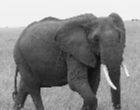

[0]


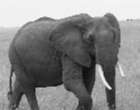

[0]


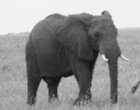

[0]


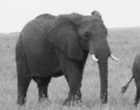

[0]


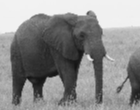

[0]


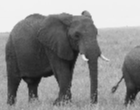

[0]


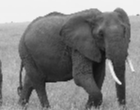

[0]


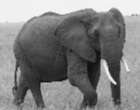

[0]


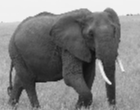

[0]


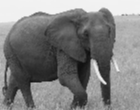

[0]


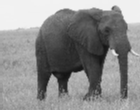

[0]


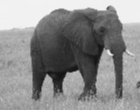

[0]


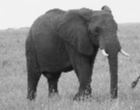

[0]


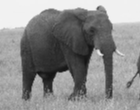

[0]


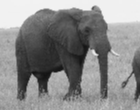

[0]


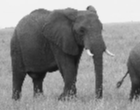

[0]


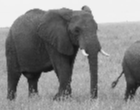

[0]


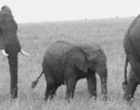

[0]


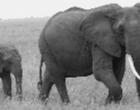

[0]


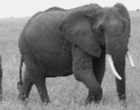

[0]


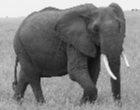

[0]


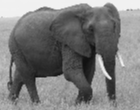

[0]


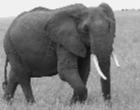

[0]


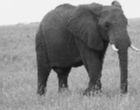

[0]


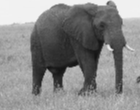

[0]


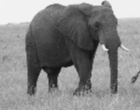

[0]


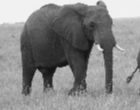

[0]


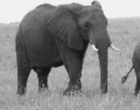

[0]


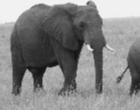

[0]


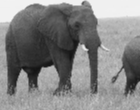

[0]


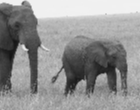

[0]


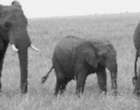

[0]


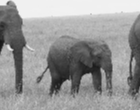

[0]


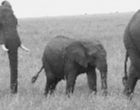

[0]


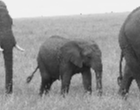

[0]


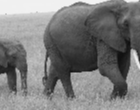

[0]


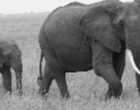

[0]


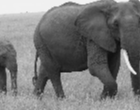

[0]


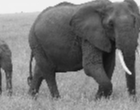

[0]


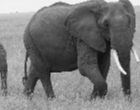

[0]


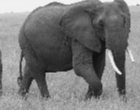

[0]


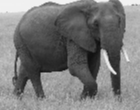

[0]


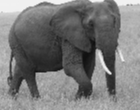

[0]


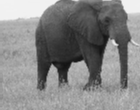

[0]


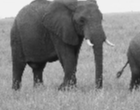

[0]


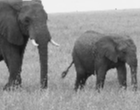

[0]


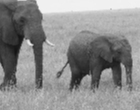

[0]


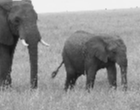

[0]


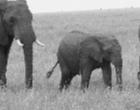

[0]


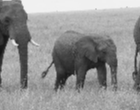

[0]


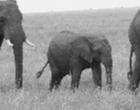

[0]


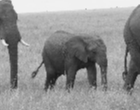

[0]


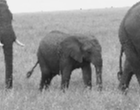

[0]


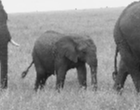

[0]


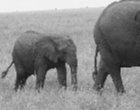

[0]


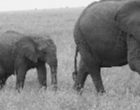

[0]


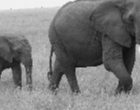

[0]


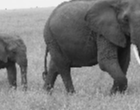

[0]


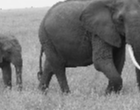

[0]


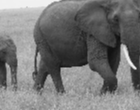

[0]


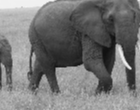

[0]


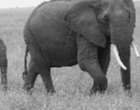

[0]


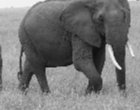

[0]


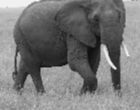

[0]


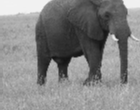

[0]


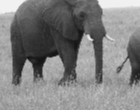

[0]


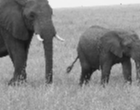

[0]


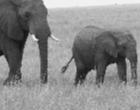

[0]


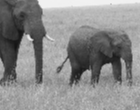

[0]


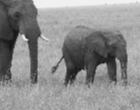

[0]


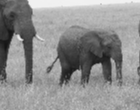

[0]


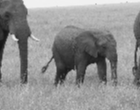

[0]


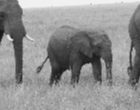

[0]


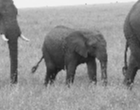

[0]


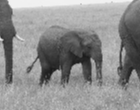

[0]


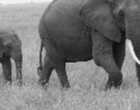

[0]


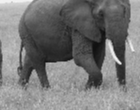

[0]


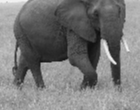

[0]


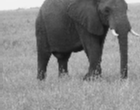

[0]


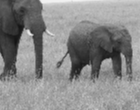

[0]


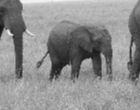

[0]


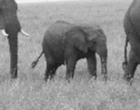

[0]


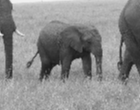

[0]


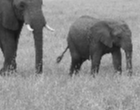

[0]


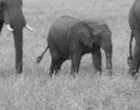

[0]


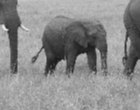

[0]


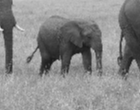

[0]


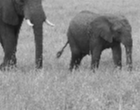

[0]


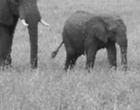

[0]


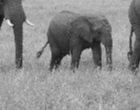

[0]


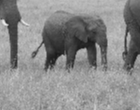

[0]


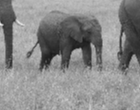

[0]


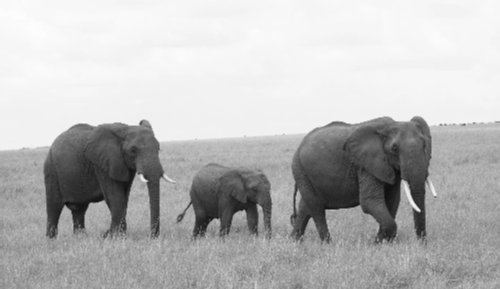

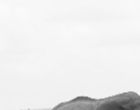

[0]


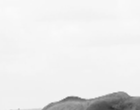

[0]


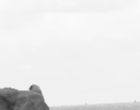

[0]


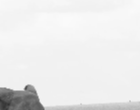

[0]


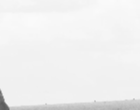

[0]


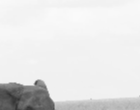

[0]


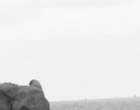

[0]


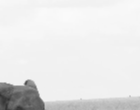

[0]


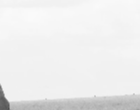

[0]


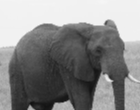

[0]


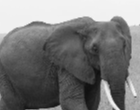

[0]


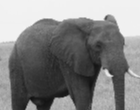

[0]


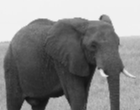

[0]


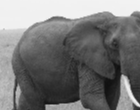

[0]


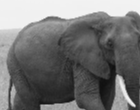

[0]


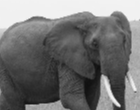

[0]


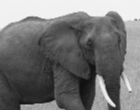

[0]


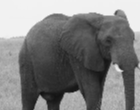

[0]


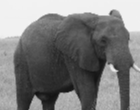

[0]


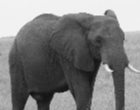

[0]


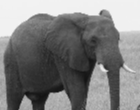

[0]


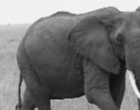

[0]


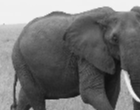

[0]


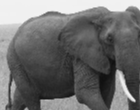

[0]


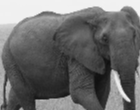

[0]


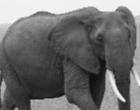

[0]


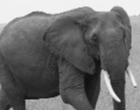

[0]


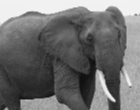

[0]


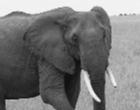

[0]


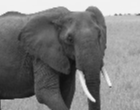

[0]


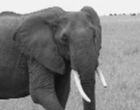

[0]


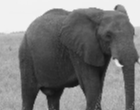

[0]


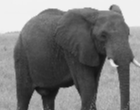

[0]


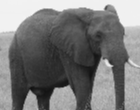

[0]


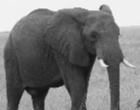

[0]


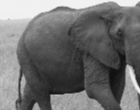

[0]


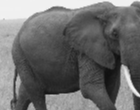

[0]


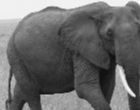

[0]


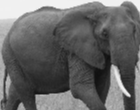

[0]


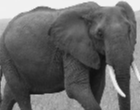

[0]


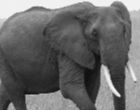

[0]


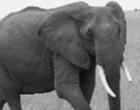

[0]


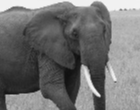

[0]


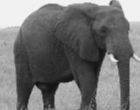

[0]


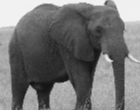

[0]


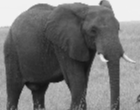

[0]


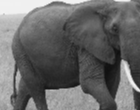

[0]


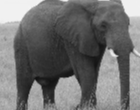

[0]


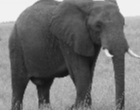

[0]


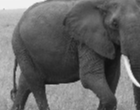

[0]


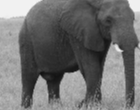

[0]


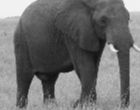

[0]


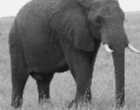

[0]


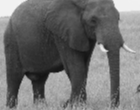

[0]


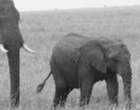

[0]


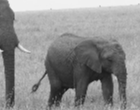

[0]


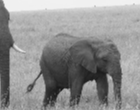

[0]


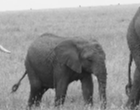

[0]


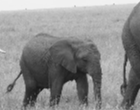

[0]


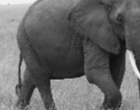

[0]


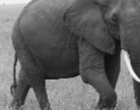

[0]


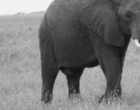

[0]


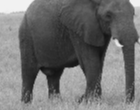

[0]


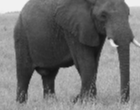

[0]


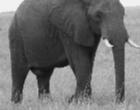

[0]


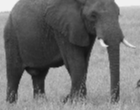

[0]


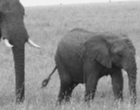

[0]


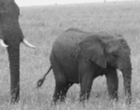

[0]


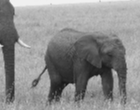

[0]


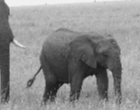

[0]


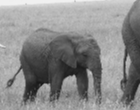

[0]


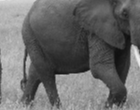

[0]


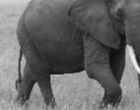

[0]


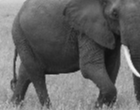

[0]


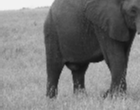

[0]


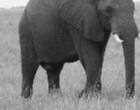

[0]


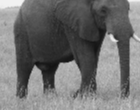

[0]


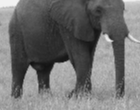

[0]


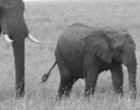

[0]


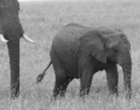

[0]


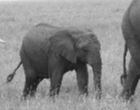

[0]


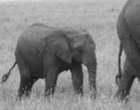

[0]


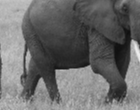

[0]


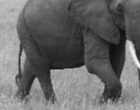

[0]


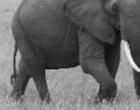

[0]


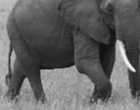

[0]


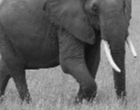

[0]


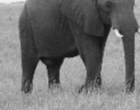

[0]


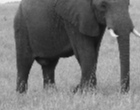

[0]


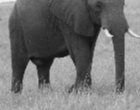

[0]


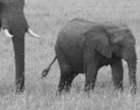

[0]


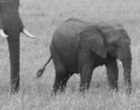

[0]


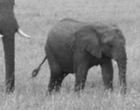

[0]


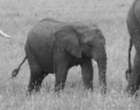

[0]


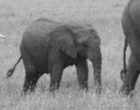

[0]


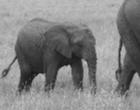

[0]


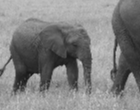

[0]


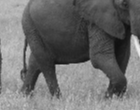

[0]


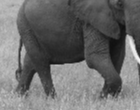

[0]


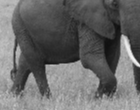

[0]


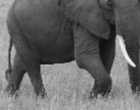

[0]


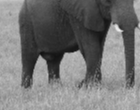

[0]


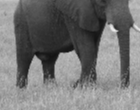

[0]


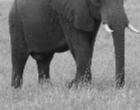

[0]


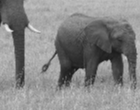

[0]


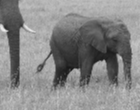

[0]


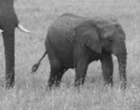

[0]


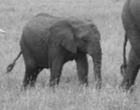

[0]


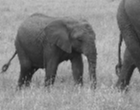

[0]


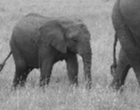

[0]


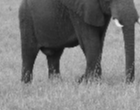

[0]


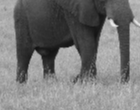

[0]


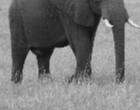

[0]


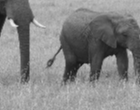

[0]


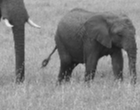

[0]


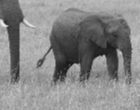

[0]


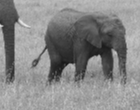

[0]


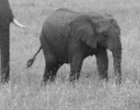

[0]


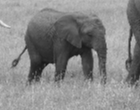

[0]


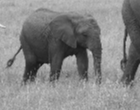

[0]


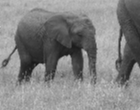

[0]


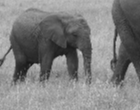

[0]


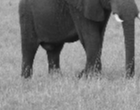

[0]


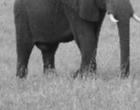

[0]


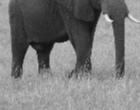

[0]


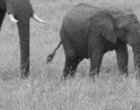

[0]


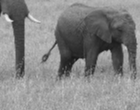

[0]


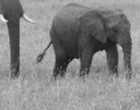

[0]


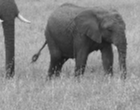

[0]


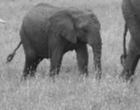

[0]


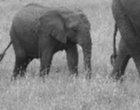

[0]


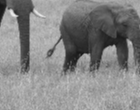

[0]


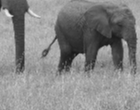

[0]


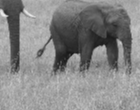

[0]


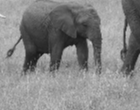

[0]


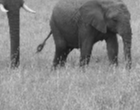

[0]
1


In [20]:
IMG_PATH = '1.jpg'
# read image
img = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)
heigh, width = img.shape
ratio = heigh/width;
for i in range(3):
  new_width = 300 + i*100;
  new_heigh = int(new_width * ratio);
  img_resize = cv2.resize(img, (new_width, new_heigh))
  img_resize = cv2.blur(img_resize, ksize=(2, 2))
  cv2_imshow(img_resize)
  x = 0
  pred=0
  while(x + 110 <= new_heigh):
    y = 0
    while(y + 140 <= new_width):
      wd = img_resize[x:x+110, y:y+140]
      wd = cv2.resize(wd, (140, 110))
      temp1 = hog.describe(wd)
      temp = model.predict([temp1])
      if temp == [0]:
        pred = 1
        cv2_imshow(wd)
        print(temp)
      y = y + 5
    x = x + 5
print(pred);

# Sử dụng KNN


In [ ]:
from sklearn import neighbors, datasets
clf = neighbors.KNeighborsClassifier(n_neighbors = 5, p = 1)
clf.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=1,
                     weights='uniform')

In [ ]:
pred = clf.predict(x_test)
print('acc: ', accuracy_score(pred, y_test))

acc:  0.28725961538461536
